In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
import os

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 100

In [5]:
discriminator = Discriminator(image_dim).to(device)
generator = Generator(z_dim, image_dim).to(device)

In [6]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [7]:
fixed_noise_np = fixed_noise.cpu().detach().numpy()

In [8]:
fixed_noise_np

array([[-0.3862463 , -3.4233747 ,  0.72197306, ..., -1.1673645 ,
         1.2188505 ,  1.3965249 ],
       [-1.1050065 ,  1.4725231 , -0.04502382, ..., -0.52206415,
         1.1224877 ,  1.7447568 ],
       [ 0.8006473 ,  0.1398376 , -0.63753086, ..., -0.06054889,
        -0.9189406 , -1.0852563 ],
       ...,
       [-0.6825593 ,  0.61469626, -0.14973502, ..., -1.30293   ,
        -0.45783475, -1.0950876 ],
       [-1.589864  , -0.33041754, -0.7845451 , ...,  1.6128688 ,
         0.9084273 ,  0.03714401],
       [ 2.2658594 ,  0.24261838, -0.64505553, ..., -0.7486352 ,
        -1.4286251 ,  1.505373  ]], dtype=float32)

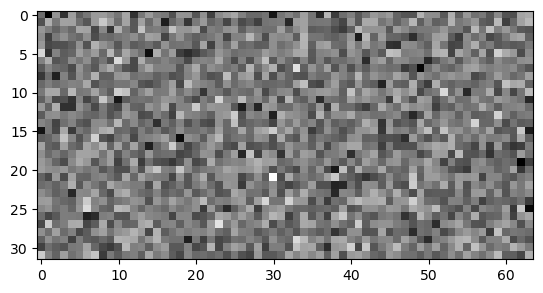

In [9]:
plt.imshow(fixed_noise_np, cmap='gray')

In [10]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [11]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)
opt_gen = optim.Adam(generator.parameters(), lr=lr)

In [13]:
criterion = nn.BCELoss()

In [14]:
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

In [15]:
step = 0
# Define the directory to save the images
save_dir = "./fake_images/"

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise)
        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                
                os.makedirs(save_dir, exist_ok=True)
                save_image(img_grid_fake, os.path.join(save_dir, f"fake_images_{step}.png"))

                step += 1

Epoch [0/100] Batch 0/1875                       Loss D: 0.6885, loss G: 0.7069
Epoch [1/100] Batch 0/1875                       Loss D: 0.1923, loss G: 1.6782
Epoch [2/100] Batch 0/1875                       Loss D: 0.6909, loss G: 0.8702
Epoch [3/100] Batch 0/1875                       Loss D: 0.8565, loss G: 0.7342
Epoch [4/100] Batch 0/1875                       Loss D: 0.8501, loss G: 0.8987
Epoch [5/100] Batch 0/1875                       Loss D: 0.7462, loss G: 0.8079
Epoch [6/100] Batch 0/1875                       Loss D: 0.6471, loss G: 1.1249
Epoch [7/100] Batch 0/1875                       Loss D: 0.6051, loss G: 1.0313
Epoch [8/100] Batch 0/1875                       Loss D: 0.7462, loss G: 0.8550
Epoch [9/100] Batch 0/1875                       Loss D: 0.4518, loss G: 1.2953
Epoch [10/100] Batch 0/1875                       Loss D: 0.5384, loss G: 1.4272
Epoch [11/100] Batch 0/1875                       Loss D: 0.5318, loss G: 1.3921
Epoch [12/100] Batch 0/1875           

In [16]:
writer_fake

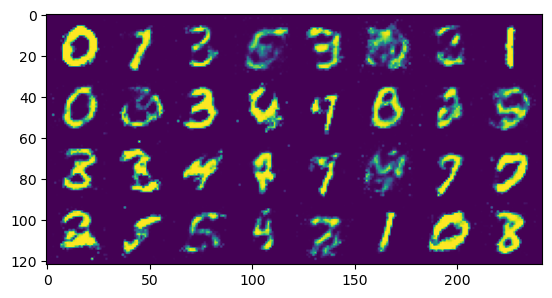

In [17]:
plt.imshow(img_grid_fake.cpu().detach().numpy()[0, :, :])

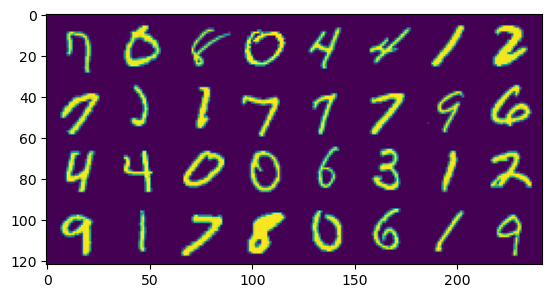

In [18]:
plt.imshow(img_grid_real.cpu().detach().numpy()[0, :, :])

In [19]:
writer_fake.close()

In [20]:
writer_real.close()